In [16]:
from torchvision.datasets import Cityscapes

import torch
print(torch.__version__)
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import sys

2.1.2


In [17]:
print('__Python VERSION: ', sys.version)
print('__PyTorch VERSION: ', torch.__version__)
print('__CUDA VERSION', )
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
print('Active CUDA Device: GPU', torch.cuda.current_device())
print('Available devices ', torch.cuda.device_count())
print('Current cuda device ', torch.cuda.current_device())

__Python VERSION:  3.8.18 (default, Sep 11 2023, 13:39:12) [MSC v.1916 64 bit (AMD64)]
__PyTorch VERSION:  2.1.2
__CUDA VERSION
__CUDNN VERSION: 8700
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [18]:
# Check if GPU is avaliable on your system
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {device}")

Training on cuda


In [19]:
import torchvision.transforms as transforms
import augmentations as A

# Define the transformations
data_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor
    transforms.Resize((256,256))
])

# Define a list of transformations
augment_tranmforms = [A.Resize((256, 256)),
                    A.RandomHorizontalFlip(),
                    A.RandomRotation(degrees=(-35, 35)),
                    A.RandomCropWithProbability(220, 0.5),
                    A.ToTensor()]

# Instanciate the Compose class with the list of transformations
augment_transforms = A.Compose(augment_tranmforms)


dataset_path = 'C:\\Users\\jakub\\Desktop\\TUe\\AIES\\Q3\\5LSM0-Neural-networks-for-computer-vision\\FinalAssignment\\archive'

# Create transformed train dataset
training_dataset = Cityscapes(dataset_path, split='train', mode='fine', target_type='semantic', transform=data_transforms, target_transform=data_transforms)

# Create augmented train dataset
augmented_dataset = Cityscapes(dataset_path, split='train', mode='fine', target_type='semantic', transform=data_transforms, target_transform=augment_transforms)

# Create transformed train dataset
validation_dataset = Cityscapes(dataset_path, split='val', mode='fine', target_type='semantic', transform=data_transforms, target_transform=data_transforms)

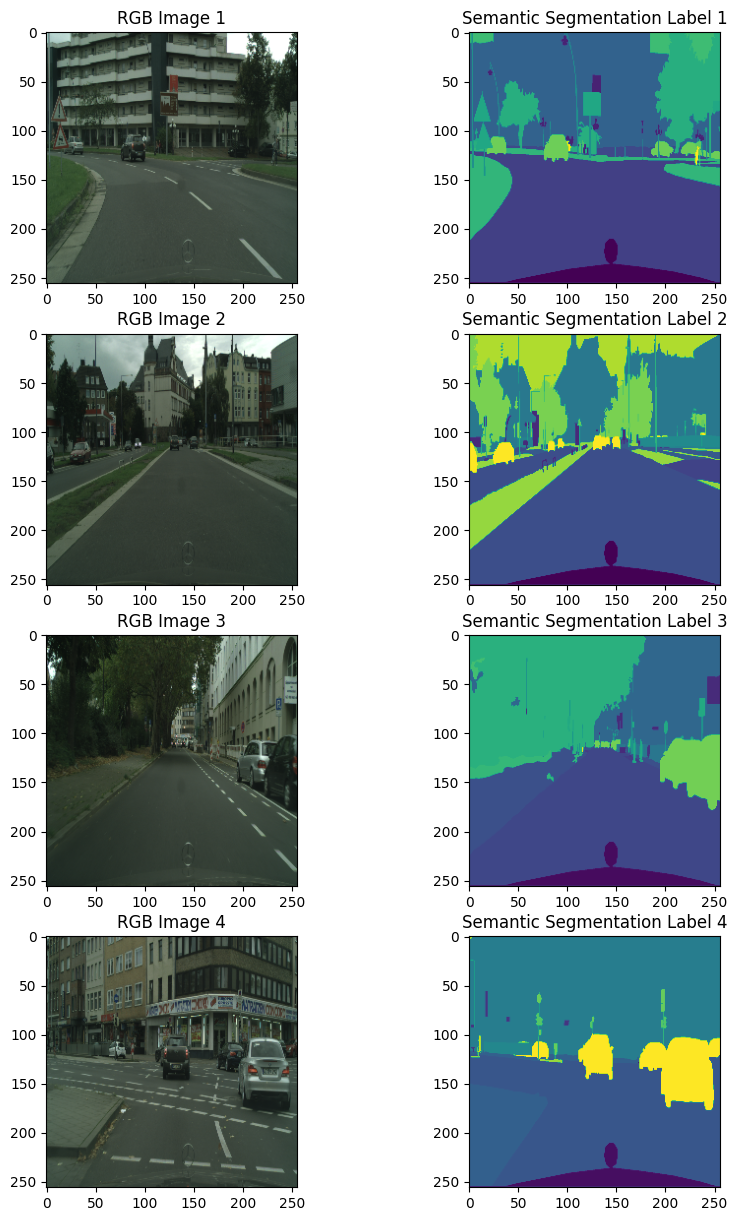

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 2, figsize=(10, 15))

for i in range(4):
    # TO DO: spec the fig size
    img, lbl = training_dataset[i]

    img_np = img.permute(1, 2, 0)
    lbl_np = lbl.permute(1, 2, 0)

    plt.subplot(4, 2, 2 * i + 1)
    plt.imshow(img_np)
    plt.title(f'RGB Image {i+1}')

    plt.subplot(4, 2, 2 * i + 2)
    plt.imshow(lbl_np)  # Adjust the colormap as needed
    plt.title(f'Semantic Segmentation Label {i+1}')

# Adjust layout to prevent overlap
# plt.tight_layout()
    
# Save a figure to a PNG format file
# plt.savefig('Cityspace-test-vis.png')

plt.show()

In [21]:
from torch.utils.data import ConcatDataset, DataLoader, random_split

# Combine the datasets
combined_dataset = ConcatDataset([training_dataset, augmented_dataset])

# Determine the lengths of the training and validation sets
total_size = len(combined_dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size  # 20% for validation

# Split the datasets
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

# Create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, 
                                pin_memory=True if torch.cuda.is_available() else False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2, 
                                pin_memory=True if torch.cuda.is_available() else False)

In [25]:
# Get the first batch of data
images, masks = next(iter(train_dataloader))

# Print the shapes of the images and masks
print(f'Images shape: {images.shape}')
print(f'Masks shape: {masks.shape}')

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\Users\jakub\anaconda3\envs\experiments\lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "c:\Users\jakub\anaconda3\envs\experiments\lib\site-packages\torch\utils\data\_utils\fetch.py", line 49, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
  File "c:\Users\jakub\anaconda3\envs\experiments\lib\site-packages\torch\utils\data\dataset.py", line 364, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
  File "c:\Users\jakub\anaconda3\envs\experiments\lib\site-packages\torch\utils\data\dataset.py", line 364, in <listcomp>
    return [self.dataset[self.indices[idx]] for idx in indices]
  File "c:\Users\jakub\anaconda3\envs\experiments\lib\site-packages\torch\utils\data\dataset.py", line 302, in __getitem__
    return self.datasets[dataset_idx][sample_idx]
  File "c:\Users\jakub\anaconda3\envs\experiments\lib\site-packages\torchvision\datasets\cityscapes.py", line 197, in __getitem__
    image, target = self.transforms(image, target)
  File "c:\Users\jakub\anaconda3\envs\experiments\lib\site-packages\torchvision\datasets\vision.py", line 96, in __call__
    target = self.target_transform(target)
TypeError: __call__() missing 1 required positional argument: 'mask'


In [8]:
# # Create training and validation dataloaders
# train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=10, shuffle=True, num_workers=2,
#                                             pin_memory=True if torch.cuda.is_available() else False)

# val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=10, shuffle=True, num_workers=2,
#                                             pin_memory=True if torch.cuda.is_available() else False)


## Training Model

In [23]:
from model import Model
import model_executables as mex

# Instanciate the model
UNet_model = Model()

# Move the model to the GPU if avaliable
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
UNet_model = UNet_model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(UNet_model.parameters(), lr=0.01)

# Train the instanciated model
mex.train_model(UNet_model, train_dataloader, val_dataloader, num_epochs=2, patience=3, criterion=criterion, optimizer=optimizer)


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\Users\jakub\anaconda3\envs\experiments\lib\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "c:\Users\jakub\anaconda3\envs\experiments\lib\site-packages\torch\utils\data\_utils\fetch.py", line 49, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
  File "c:\Users\jakub\anaconda3\envs\experiments\lib\site-packages\torch\utils\data\dataset.py", line 364, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
  File "c:\Users\jakub\anaconda3\envs\experiments\lib\site-packages\torch\utils\data\dataset.py", line 364, in <listcomp>
    return [self.dataset[self.indices[idx]] for idx in indices]
  File "c:\Users\jakub\anaconda3\envs\experiments\lib\site-packages\torch\utils\data\dataset.py", line 302, in __getitem__
    return self.datasets[dataset_idx][sample_idx]
  File "c:\Users\jakub\anaconda3\envs\experiments\lib\site-packages\torchvision\datasets\cityscapes.py", line 197, in __getitem__
    image, target = self.transforms(image, target)
  File "c:\Users\jakub\anaconda3\envs\experiments\lib\site-packages\torchvision\datasets\vision.py", line 96, in __call__
    target = self.target_transform(target)
TypeError: __call__() missing 1 required positional argument: 'mask'


In [11]:
# Create a test dataset
# Create transformed train dataset
test_dataset = Cityscapes(dataset_path, split='test', mode='fine', target_type='semantic', transform=data_transforms, target_transform=data_transforms)
# Create a test data loader
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True, num_workers=2,
                                            pin_memory=True if torch.cuda.is_available() else False)

In [12]:
from utils import LABELS

class_colors = {label.name: label.color for label in LABELS}

# for class_name, color in class_colors.items():
#     print(f"{class_name}: {color}")

colors_cityspace = [label.color for label in LABELS]
class_names_cityspace = [label.name for label in LABELS]


# Create a dictionary that maps class names to class colors
class_colors = {i: color for i, color in enumerate(colors_cityspace)}

# Crete a dictionary that maps class names to class colors
class_names = {i: name for i, name in enumerate(class_names_cityspace)}

print(class_colors)



{0: (0, 0, 0), 1: (0, 0, 0), 2: (0, 0, 0), 3: (0, 0, 0), 4: (0, 0, 0), 5: (111, 74, 0), 6: (81, 0, 81), 7: (128, 64, 128), 8: (244, 35, 232), 9: (250, 170, 160), 10: (230, 150, 140), 11: (70, 70, 70), 12: (102, 102, 156), 13: (190, 153, 153), 14: (180, 165, 180), 15: (150, 100, 100), 16: (150, 120, 90), 17: (153, 153, 153), 18: (153, 153, 153), 19: (250, 170, 30), 20: (220, 220, 0), 21: (107, 142, 35), 22: (152, 251, 152), 23: (70, 130, 180), 24: (220, 20, 60), 25: (255, 0, 0), 26: (0, 0, 142), 27: (0, 0, 70), 28: (0, 60, 100), 29: (0, 0, 90), 30: (0, 0, 110), 31: (0, 80, 100), 32: (0, 0, 230), 33: (119, 11, 32), 34: (0, 0, 142)}


In [13]:
# import random

# Existing color coding for the first 35 classes
# colors_cityscapes = {
#     0: (0, 0, 0),
#     1: (138, 187, 36),
#     2: (138, 94, 28),
#     3: (68, 193, 94),
#     4: (0, 143, 21),
#     5: (122, 210, 11),
#     6: (120, 177, 17),
#     7: (152, 2, 32),
#     8: (173, 251, 20),
#     9: (79, 45, 163),
#     10: (95, 149, 240),
#     11: (179, 195, 232),
#     12: (205, 22, 174),
#     13: (143, 112, 157),
#     14: (120, 249, 119),
#     15: (154, 100, 13),
#     16: (17, 175, 253),
#     17: (10, 18, 16),
#     18: (67, 65, 54),
#     19: (132, 94, 164),
#     20: (205, 85, 169),
#     21: (6, 242, 80),
#     22: (45, 104, 119),
#     23: (122, 163, 180),
#     24: (81, 47, 145),
#     25: (150, 168, 7),
#     26: (6, 147, 255),
#     27: (200, 55, 78),
#     28: (208, 149, 214),
#     29: (2, 241, 14),
#     30: (12, 148, 250),
#     31: (153, 181, 176),
#     32: (92, 40, 146),
#     33: (252, 53, 128),
#     34: (80, 132, 172),
#     35: (179, 17, 75),
#     255: (255, 255, 255)
# }

# Class names for the first 35 classes
# class_names_cityscapes = [
#     'unlabeled','ego vehicle', 'rectification border', 'out of roi', 'static', 'dynamic', 'ground', 'road', 'sidewalk',
#     'parking', 'rail track', 'building', 'wall', 'fence', 'guard rail', 'bridge', 'tunnel', 'pole', 'polegroup',
#     'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus',
#     'caravan', 'trailer', 'train', 'motorcycle', 'bicycle', 'license plate'
# ]

# color_list = []
# # Generate random colors for the remaining classes (22 to 34)
# for i in range(len(class_names_cityscapes_updated)):
#     color_list.append([random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)])

# # Print the updated color coding
# for idx, color in enumerate(color_list):
#     print(f"{idx}: {color}")

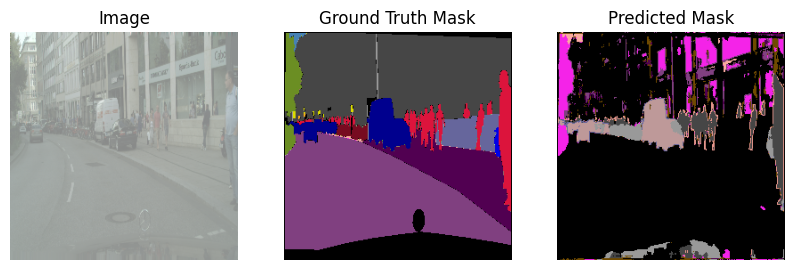

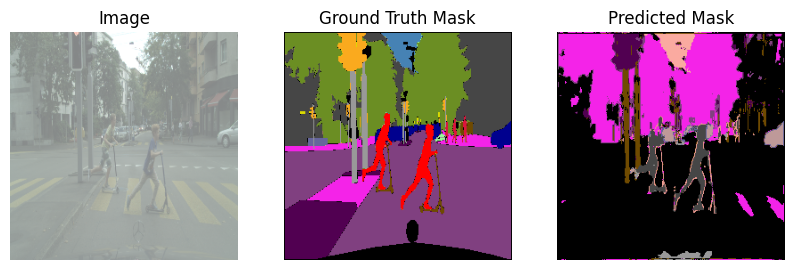

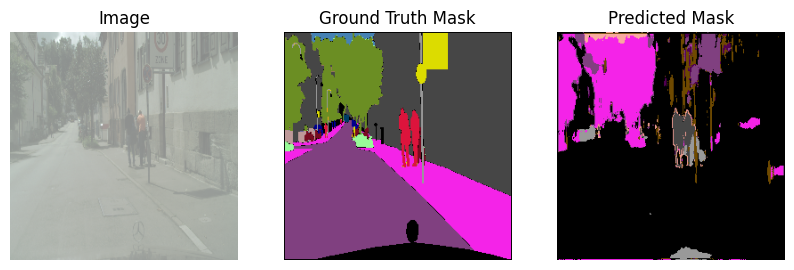

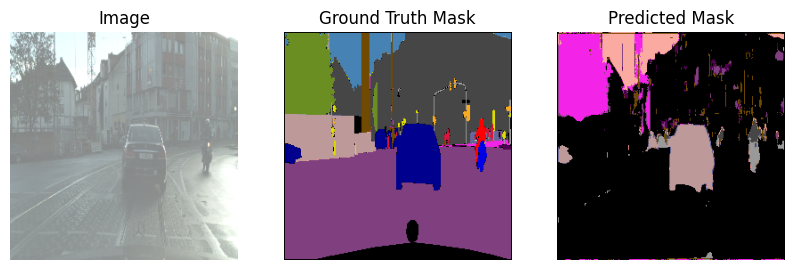

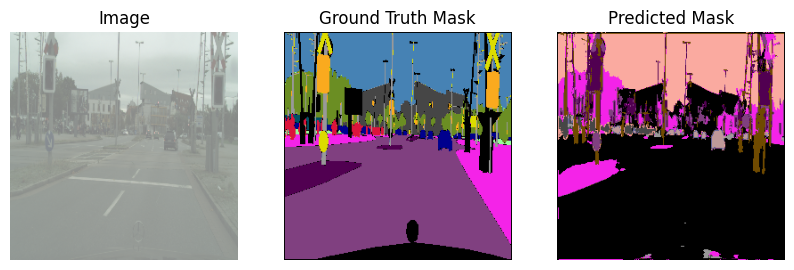

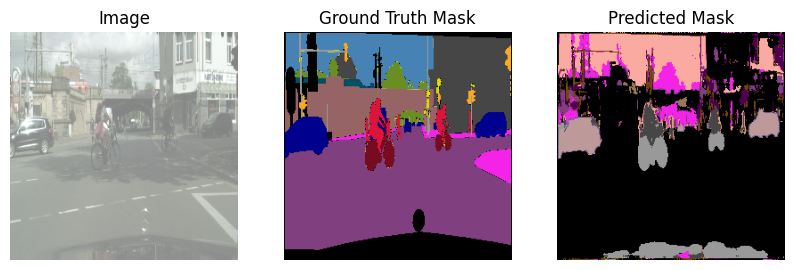

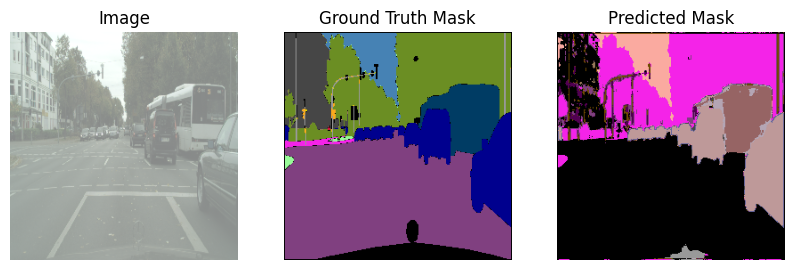

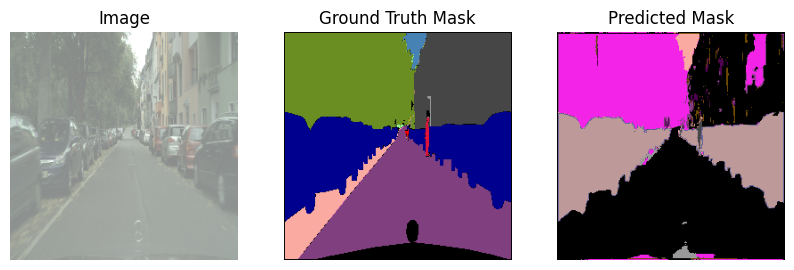

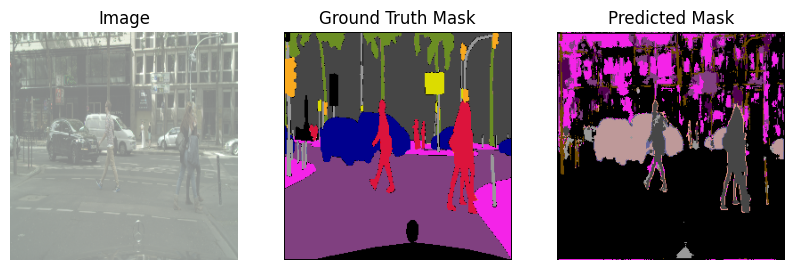

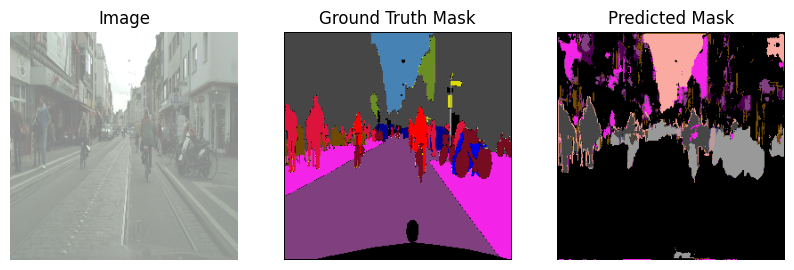

In [14]:
from model import Model
from model_vis import visualize_segmentation_cityscapes

# Instanciate Model()
eval_model = Model()

# Specify the checkpoint file path
checkpoint_path = 'C:\\Users\\jakub\\Desktop\\TUe\\AIES\\Q3\\5LSM0-Neural-networks-for-computer-vision\\FinalAssignment\\model_checkpoints\\model_checkpoint_epoch_60_Mar14.pth'
device = torch.device('cpu') 

checkpoint = torch.load(checkpoint_path, map_location=device)
eval_model.load_state_dict(checkpoint)

# Call the function with the checkpoint path
visualize_segmentation_cityscapes(eval_model, train_loader, coloring=class_colors, num_examples=1)

In [15]:
# Load in the checkpoint file and saving a new one with soely the model.state_dict

# Instanciate Model()
# model = Model()

# Specify the checkpoint file path
# checkpoint_path = 'C:\\Users\\jakub\\Desktop\\TUe\\AIES\\Q3\\5LSM0-Neural-networks-for-computer-vision\\FinalAssignment\\model_checkpoints\\model_checkpoint_epoch_50.pth'
# device = torch.device('cpu') 

# checkpoint = torch.load(checkpoint_path, map_location=device)
# model.load_state_dict(checkpoint['model_state_dict'])

# torch.save(model.state_dict(), 'C:\\Users\\jakub\\Desktop\\TUe\\AIES\\Q3\\5LSM0-Neural-networks-for-computer-vision\\FinalAssignment\\model_checkpoints\\model.pth')